In [4]:
# imports, zorg dat al deze packages aanwezig zijn.
import requests
import rasterio
from requests.auth import HTTPBasicAuth
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns
import glob
import os
import re
import pandas as pd
from datetime import timedelta
from dateutil import parser as dateparser
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics, cross_validation
from fbprophet.plot import plot_cross_validation_metric
from tabulate import tabulate

import itertools
import pandas as pd

# Univariate time series forecast (Evaporation)
In dit voorbeeld wordt evaporation timeseries data gebruikt om een twee jaar forecast te doen. Hiervoor wordt Facebooks open source timeseries forecast model Prophet gebruikt. Dit model is erg goed in het maken van een forecast gebaseerd op één variable.

## Data ophalen
Eerst wordt de data opgehaald van de WIWB API. We nemen alle waarden vanaf het jaar 2000.

In [9]:
# authenticatie
# import credentials, comment and insert your own below.
from credentials import auth

# put in your own credentials
username = ""
password = ""
auth = HTTPBasicAuth(username, password)

headerjson = {"Accept": "application/json",
             "Content-Type": "application/json"}

bodyjson = {
    "Readers": [
        {
            "DataSourceCode": "Knmi.Evaporation",
            "Settings": {
                "StartDate": "19900101000000",
                "EndDate": "20200201100000",
                "VariableCodes": [
                    "Evaporation"
                ],
                "LocationCodes": [
                    "06260",
                ]
            }
        }
    ],
    "Exporter": {
        "DataFormatCode": "json"
    }
}

response = requests.post("https://wiwb.hydronet.com/api/timeseries/get", auth=auth, headers=headerjson, json=bodyjson)
print("status code (200 is ok): {}".format(response.status_code))

evapo_dict = response.json()

status code (200 is ok): 200


## Data verwerken
Vervolgens moet de de data omgevormd worden naar het door Prophet gewenste format.

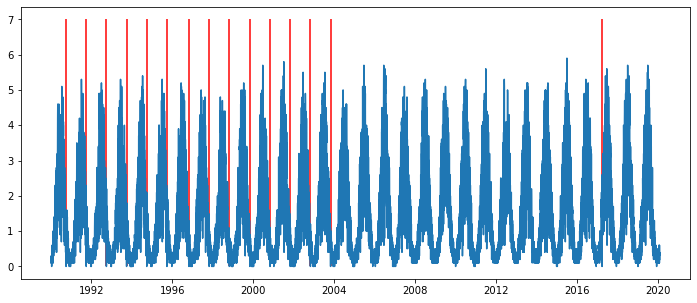

In [205]:
# haal alle waarden en datums uit de response en stop ze in aparte lijsten
values = [entry['Value'] for entry in evapo_dict['Data'][0]['Data']]
dates = [dateparser.parse(entry['DateTime']) for entry in evapo_dict['Data'][0]['Data']]

# maak de dataframe
evapo_df = pd.DataFrame(index=dates, data=values, columns=['y'])

# haal errors uit de dataframe en zet in aparte dataframe
error_df = evapo_df.loc[evapo_df['y'] < -2000].copy()
error_df['y'] = 6

# zet errors in evaporation dataframe naar 0 voor het plotten
evapo_df.loc[evapo_df['y'] < -2000] = 0

plt.figure(figsize=(12,5))
plt.plot(evapo_df)

# plot errors in rood
plt.vlines(error_df.index, 0,7, color='r')
plt.show()
evapo_df['ds'] = dates


## Model fitten en forecast doen
Nu alle data in het goede formaat is kunnen we een forecast doen

In [58]:
# fit forecast model
m = Prophet()
m.fit(evapo_df)

# make empty future dataframe
future = m.make_future_dataframe(periods=730)

# do forecast
forecast = m.predict(future)
forecast.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-02,1.513312,-0.835331,1.102679,1.513312,1.513312,-1.404594,-1.404594,-1.404594,0.000630,0.000630,0.000630,-1.405224,-1.405224,-1.405224,0.0,0.0,0.0,0.108718
1,2000-01-03,1.513391,-0.821046,1.038308,1.513391,1.513391,-1.403377,-1.403377,-1.403377,0.001267,0.001267,0.001267,-1.404644,-1.404644,-1.404644,0.0,0.0,0.0,0.110014
2,2000-01-04,1.513469,-0.870318,1.043831,1.513469,1.513469,-1.366392,-1.366392,-1.366392,0.037634,0.037634,0.037634,-1.404025,-1.404025,-1.404025,0.0,0.0,0.0,0.147078
3,2000-01-05,1.513548,-0.851448,1.098062,1.513548,1.513548,-1.411649,-1.411649,-1.411649,-0.008331,-0.008331,-0.008331,-1.403319,-1.403319,-1.403319,0.0,0.0,0.0,0.101899
4,2000-01-06,1.513626,-0.888092,1.006063,1.513626,1.513626,-1.412780,-1.412780,-1.412780,-0.010310,-0.010310,-0.010310,-1.402470,-1.402470,-1.402470,0.0,0.0,0.0,0.100846


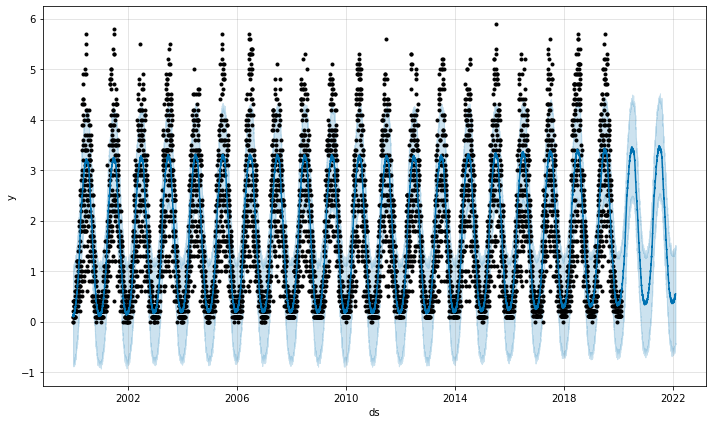

In [59]:
fig1 = m.plot(forecast)

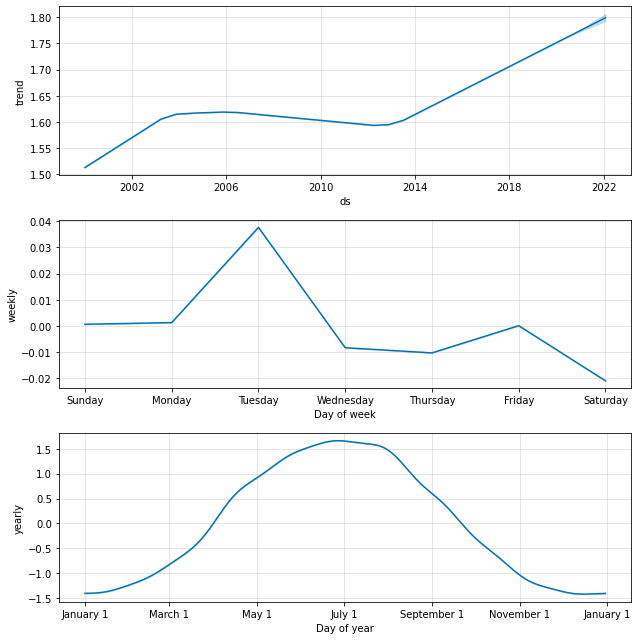

In [60]:
# het model maakt een forecast door het signaal op te delen in componenten. dit zijn de algemene trend en de periodische trends, in dit geval jaarlijks en wekelijks.
fig2 = m.plot_components(forecast)

## Validatie van het model, hoe goed is de fit?
om de performance van het model te bepalen gebruiken we cross validation. hierin wordt steeds een willekeurig stuk van de data gebruikt om een voorspelling te doen die dan wordt vergeleken met de daadwerkelijke historie.

In [61]:
# begin 2 jaar vanaf het eerste meetpunt, stap met 180 dagen door de data heen en voorspel steeds 365 dagen in de toekomst
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
df_cv.head()

INFO:fbprophet:Making 35 forecasts with cutoffs between 2002-05-01 00:00:00 and 2019-02-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2002-05-02,2.628724,1.729192,3.608036,2.699219,2002-05-01
1,2002-05-03,2.746973,1.863336,3.664718,1.300781,2002-05-01
2,2002-05-04,2.819835,1.961258,3.723417,2.900391,2002-05-01
3,2002-05-05,2.894385,2.034125,3.815201,0.500000,2002-05-01
4,2002-05-06,2.916614,2.029082,3.799201,0.500000,2002-05-01


In [63]:
df_p = performance_metrics(df_cv, rolling_window=1)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,365 days,0.608584,0.780118,0.558085,0.32979,0.800157


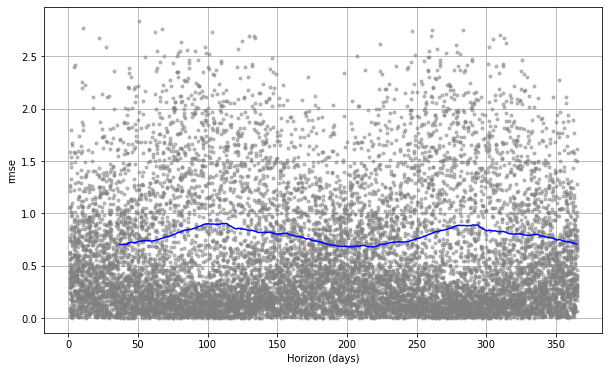

In [32]:
# error bij het forecasten van een jaar aan data. We zien dat er twee pieken zijn waar de error hoger is dan in de rest van het jaar
fig = plot_cross_validation_metric(df_cv, metric='rmse')

## Tuning van het model
door de trainings parameters aan te passen kunnen we de performance van het model verbeteren.

In [ ]:
# if you don't have a good cpu remove some of these parameter sweeps.
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0], # I don't think evaporation will change based on holidays
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters, this will take a while
for params in all_params:
    m = Prophet(**params).fit(evapo_df)  # Fit model with given params
    df_cv = cross_validation(m, parallel="processes", initial='730 days', period='180 days', horizon='365 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

### Als tuning te lang duurt..
stop de execution van de bovenstaande cel en run de cell hieronder om de resultaten so far te gebruiken.

In [64]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = 100
tuning_results['rmse'].iloc[:len(rmses)] = rmses

/home/parting/anaconda3/envs/WIWB/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Resultaten van de hyperparameter tuning

In [49]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(tabulate(tuning_results.sort_values(by=['rmse']), headers='keys', tablefmt='psql'))

+-----+---------------------------+---------------------------+------------------------+--------------------+------------+
|     |   changepoint_prior_scale |   seasonality_prior_scale |   holidays_prior_scale | seasonality_mode   |       rmse |
|-----+---------------------------+---------------------------+------------------------+--------------------+------------|
|  46 |                     0.01  |                      0.1  |                  10    | additive           |   0.779819 |
|  44 |                     0.01  |                      0.1  |                   1    | additive           |   0.779819 |
|  42 |                     0.01  |                      0.1  |                   0.1  | additive           |   0.779819 |
|  40 |                     0.01  |                      0.1  |                   0.01 | additive           |   0.779819 |
|  50 |                     0.01  |                      1    |                   0.1  | additive           |   0.779963 |
|  52 |         

## Gebruik de beste parameters om het model opnieuw te fitten

In [52]:
# best params = {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [55]:
# fit forecast model
m = Prophet(**best_params)
m.fit(evapo_df)

# make empty future dataframe
future = m.make_future_dataframe(periods=730)

# do forecast
forecast = m.predict(future)
forecast.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-02,1.548392,-0.881392,1.176783,1.548392,1.548392,-1.403002,-1.403002,-1.403002,0.000592,0.000592,0.000592,-1.403595,-1.403595,-1.403595,0.0,0.0,0.0,0.145390
1,2000-01-03,1.548413,-0.896797,1.122149,1.548413,1.548413,-1.401897,-1.401897,-1.401897,0.001241,0.001241,0.001241,-1.403138,-1.403138,-1.403138,0.0,0.0,0.0,0.146516
2,2000-01-04,1.548435,-0.822218,1.188641,1.548435,1.548435,-1.365044,-1.365044,-1.365044,0.037594,0.037594,0.037594,-1.402638,-1.402638,-1.402638,0.0,0.0,0.0,0.183390
3,2000-01-05,1.548456,-0.795193,1.159775,1.548456,1.548456,-1.410368,-1.410368,-1.410368,-0.008325,-0.008325,-0.008325,-1.402043,-1.402043,-1.402043,0.0,0.0,0.0,0.138088
4,2000-01-06,1.548477,-0.835817,0.976358,1.548477,1.548477,-1.411590,-1.411590,-1.411590,-0.010290,-0.010290,-0.010290,-1.401299,-1.401299,-1.401299,0.0,0.0,0.0,0.136888


## Final forecast

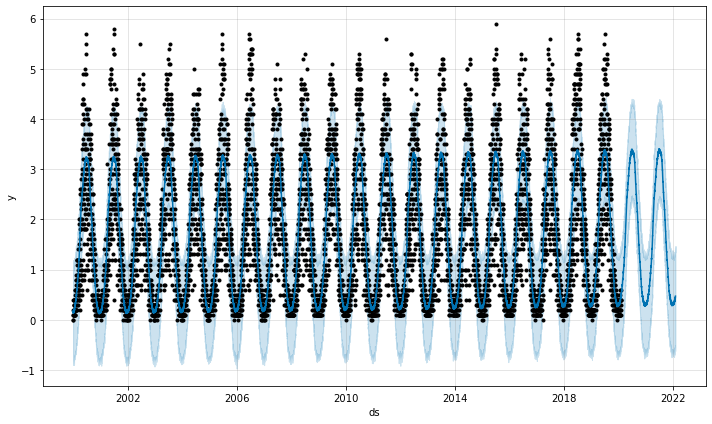

In [56]:
fig1 = m.plot(forecast)

# Anomaly detection

In [70]:
evapo_df = response.json()

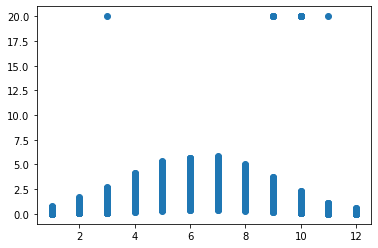

In [548]:
# haal alle waarden en datums uit de response en stop ze in aparte lijsten
values = [entry['Value'] for entry in evapo_dict['Data'][0]['Data']]
dates = [dateparser.parse(entry['DateTime']) for entry in evapo_dict['Data'][0]['Data']]

# maak de dataframe
evapo_df = pd.DataFrame(index=dates, data=values, columns=['y'])

# alle nan waarden zijn -9999, ik verander die hier naar een makkelijker te plotten waarde
evapo_df.loc[evapo_df['y'] == -9999] = 20

evapo_df['month_of_year'] = evapo_df.index.month

plt.scatter(x=evapo_df['month_of_year'], y=evapo_df['y'])

In [549]:
print(len(evapo_df))
evapo_df.head()

10988


,y,month_of_year
1990-01-02,0.099609,1
1990-01-03,0.099609,1
1990-01-04,0.099609,1
1990-01-05,0.099609,1
1990-01-06,0.099609,1


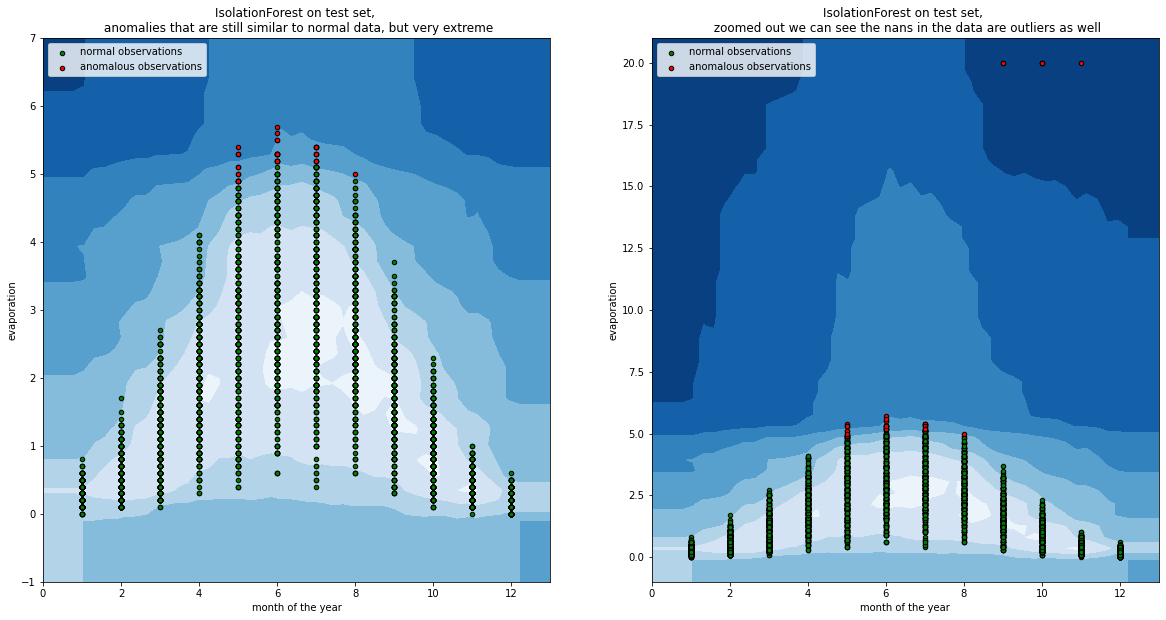

In [590]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

rng = np.random.RandomState(42)

X_train, X_test = train_test_split(np.array(evapo_df[['month_of_year', 'y']]), test_size=0.4)

# X_train[X_train[:,1] > 0] = 0 #I know NaN's are at -10000, and I will remove them here from the training set so the new nans show up as anomalies
# X_test[X_test[:,1] < 0] = 10

# fit the model, contamination is the percentage of anomalous examples expected in the dataset.
clf = IsolationForest(max_samples=200, random_state=rng, n_jobs=-1, contamination=0.01)
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(0, 13, 50), np.linspace(-1, 10, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(20,10))
ax1 = plt.subplot(1, 2, 1)
plt.title("IsolationForest on test set, \n anomalies that are still similar to normal data, but very extreme")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

normal = np.where(y_pred_test == 1)
anomalous = np.where(y_pred_test == -1)

b2 = plt.scatter(X_test[normal, 0], X_test[normal, 1], c='green',
                 s=2_0, edgecolor='k')
b2 = plt.scatter(X_test[anomalous, 0], X_test[anomalous, 1], c='red',
                 s=2_0, edgecolor='k')

plt.axis('tight')
plt.xlim((0, 13))
plt.ylim((-1, 7))
plt.legend([b1, b2],
           ["normal observations",
            "anomalous observations"],
           loc="upper left")

##################### figure 2, zoomed out ########################
ax2 = plt.subplot(1, 2, 2)
# ax.set_yscale('log')
plt.title("IsolationForest on test set, \n zoomed out we can see the nans in the data are outliers as well")

# xx, yy = np.meshgrid(np.linspace(0, 13, 50), np.linspace(-11000, 11, 50))
xx, yy = np.meshgrid(np.linspace(0, 13, 50), np.linspace(-1, 21, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

normal = np.where(y_pred_test == 1)
anomalous = np.where(y_pred_test == -1)

b1 = plt.scatter(X_test[normal, 0], X_test[normal, 1], c='green',
                 s=2_0, edgecolor='k')
b2 = plt.scatter(X_test[anomalous, 0], X_test[anomalous, 1], c='red',
                 s=2_0, edgecolor='k')

plt.axis('tight')
plt.xlim((0, 13))

ax1.set_xlabel('month of the year', fontsize=10)
ax1.set_ylabel('evaporation', fontsize=10)

ax2.set_xlabel('month of the year', fontsize=10)
ax2.set_ylabel('evaporation', fontsize=10)

# Create a Rectangle patch
import matplotlib.patches as patches
rect = patches.Rectangle((8,-10500),3,1000,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax2.add_patch(rect)

# plt.ylim((-11000, 100))
plt.legend([b1, b2],
           ["normal observations",
            "anomalous observations"],
           loc="upper left")
plt.show()

In [246]:
normal[0].shape

(998,)

# Anomaly detection op KNMI Knmi Naval Warnings


In [328]:
headerjson = {"Accept": "application/json", "Content-Type": "application/json"}


bodyjson = {
    "Readers": [
    {
    "DataSourceCode": "Knmi.Warnings",
    "Settings": {
        "StartDate": "20001201000000",
        "EndDate": "20201102000000",
        "VariableCodes": ["Warning.Wind", "Warning.Slipperiness.Snow", "Warning.Vision", "Warning.Storm", "Warning.Whirlwind.Waterspout", "Warning.Heat"],
        "LocationCodes": ["WAE"]
        }
    }]
}
# ["Warning.Wind", "Warning.Slipperiness.Snow", "Warning.Vision", "Warning.Storm", "Warning.Whirlwind.Waterspout", "Warning.Heat"],

response = requests.post("https://wiwb.hydronet.com/api/timeseries/get", auth=auth, headers=headerjson, json=bodyjson)

In [ ]:
values_wind = [entry['Value'] for entry in warning_dict['Data'][0]['Data'] if entry['Availability'] != 0]
dates_wind = [date for val, date in zip(values_wind, dates) if val == 1]

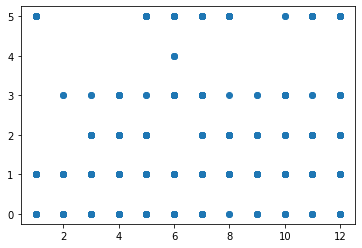

In [560]:
warning_dict = response.json()
# warning_dict
# warning_dict['Data'][0]['Data']

samples = []

# wind
# print(warning_dict['Data'][0]['VariableCode'])
values_wind = [entry['Value'] for entry in warning_dict['Data'][0]['Data'] if entry['Availability'] != 0]
dates_wind = [dateparser.parse(entry['DateTime']) for entry in warning_dict['Data'][0]['Data'] if entry['Availability'] != 0]
obs_wind = [date for val, date in zip(values_wind, dates) if val == 1]
# append samples in format [date_of_month, class]
for date in obs_wind:
    samples.append([date.month, 0, date])

# snow
values_slipsnow = [entry['Value'] for entry in warning_dict['Data'][1]['Data'] if entry['Availability'] != 0]
dates_slipsnow = [dateparser.parse(entry['DateTime']) for entry in warning_dict['Data'][1]['Data'] if entry['Availability'] != 0]
obs_slipsnow = [date for val, date in zip(values_slipsnow, dates) if val == 1]
# append samples in format [date_of_month, class]
for date in obs_slipsnow:
    samples.append([date.month, 1, date])

# vision
values_vision = [entry['Value'] for entry in warning_dict['Data'][2]['Data'] if entry['Availability'] != 0]
dates_vision = [dateparser.parse(entry['DateTime']) for entry in warning_dict['Data'][2]['Data'] if entry['Availability'] != 0]
obs_vision = [date for val, date in zip(values_vision, dates) if val == 1]
# append samples in format [date_of_month, class]
for date in obs_vision:
    samples.append([date.month, 2, date])

# storm
values_storm = [entry['Value'] for entry in warning_dict['Data'][3]['Data'] if entry['Availability'] != 0]
dates_storm = [dateparser.parse(entry['DateTime']) for entry in warning_dict['Data'][3]['Data'] if entry['Availability'] != 0]
obs_storm = [date for val, date in zip(values_storm, dates) if val == 1]
# append samples in format [date_of_month, class]
for date in obs_storm:
    samples.append([date.month, 3, date])

# whirlwaterspout
values_whirlwaterspout = [entry['Value'] for entry in warning_dict['Data'][4]['Data'] if entry['Availability'] != 0]
dates_whirlwaterspout = [dateparser.parse(entry['DateTime']) for entry in warning_dict['Data'][4]['Data'] if entry['Availability'] != 0]
obs_whirlwaterspout = [date for val, date in zip(values_whirlwaterspout, dates) if val == 1]
# append samples in format [date_of_month, class]
for date in obs_whirlwaterspout:
    samples.append([date.month, 4, date])

# heat
values_heat = [entry['Value'] for entry in warning_dict['Data'][5]['Data'] if entry['Availability'] != 0]
dates_heat = [dateparser.parse(entry['DateTime']) for entry in warning_dict['Data'][5]['Data'] if entry['Availability'] != 0]
obs_heat = [date for val, date in zip(values_heat, dates) if val == 1]
# append samples in format [date_of_month, class]
for date in obs_heat:
    samples.append([date.month, 5, date])

warning_df = pd.DataFrame(data=samples, columns=['month_of_year', 'warning_type', 'date'])

# warning_df = pd.DataFrame(index=dates, columns=['warning', 'month_of_year'])
# warning_df['warning'] = warnings
# warning_df['month_of_year'] = month_of_year
plt.scatter(x=warning_df['month_of_year'], y=warning_df['warning_type'])
plt.show()

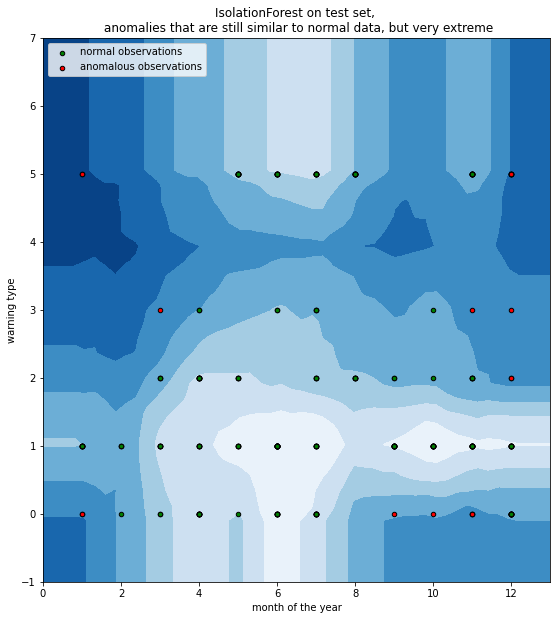

In [553]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

rng = np.random.RandomState(42)

X_train, X_test = train_test_split(np.array(warning_df[['month_of_year', 'warning_type']]), test_size=0.3)

# fit the model, contamination is the percentage of anomalous examples expected in the dataset.
clf = IsolationForest(max_samples=200, random_state=rng, n_jobs=-1, contamination=0.1)
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(0, 13, 50), np.linspace(-1, 10, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(20,10))
ax = plt.subplot(1, 2, 1)

# plt.xlabel('x')
# plt.ylabel('y')
plt.title("IsolationForest on test set, \n anomalies that are still similar to normal data, but very extreme")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

normal = np.where(y_pred_test == 1)
anomalous = np.where(y_pred_test == -1)

b2 = plt.scatter(X_test[normal, 0], X_test[normal, 1], c='green',
                 s=2_0, edgecolor='k')
b2 = plt.scatter(X_test[anomalous, 0], X_test[anomalous, 1], c='red',
                 s=2_0, edgecolor='k')

# ax = plt.axis
ax.set_xlabel('month of the year', fontsize=10)
ax.set_ylabel('warning type', fontsize=10)

plt.axis('tight')

plt.xlim((0, 13))
plt.ylim((-1, 7))
plt.legend([b1, b2],
           ["normal observations",
            "anomalous observations"],
           loc="upper left")
plt.show()

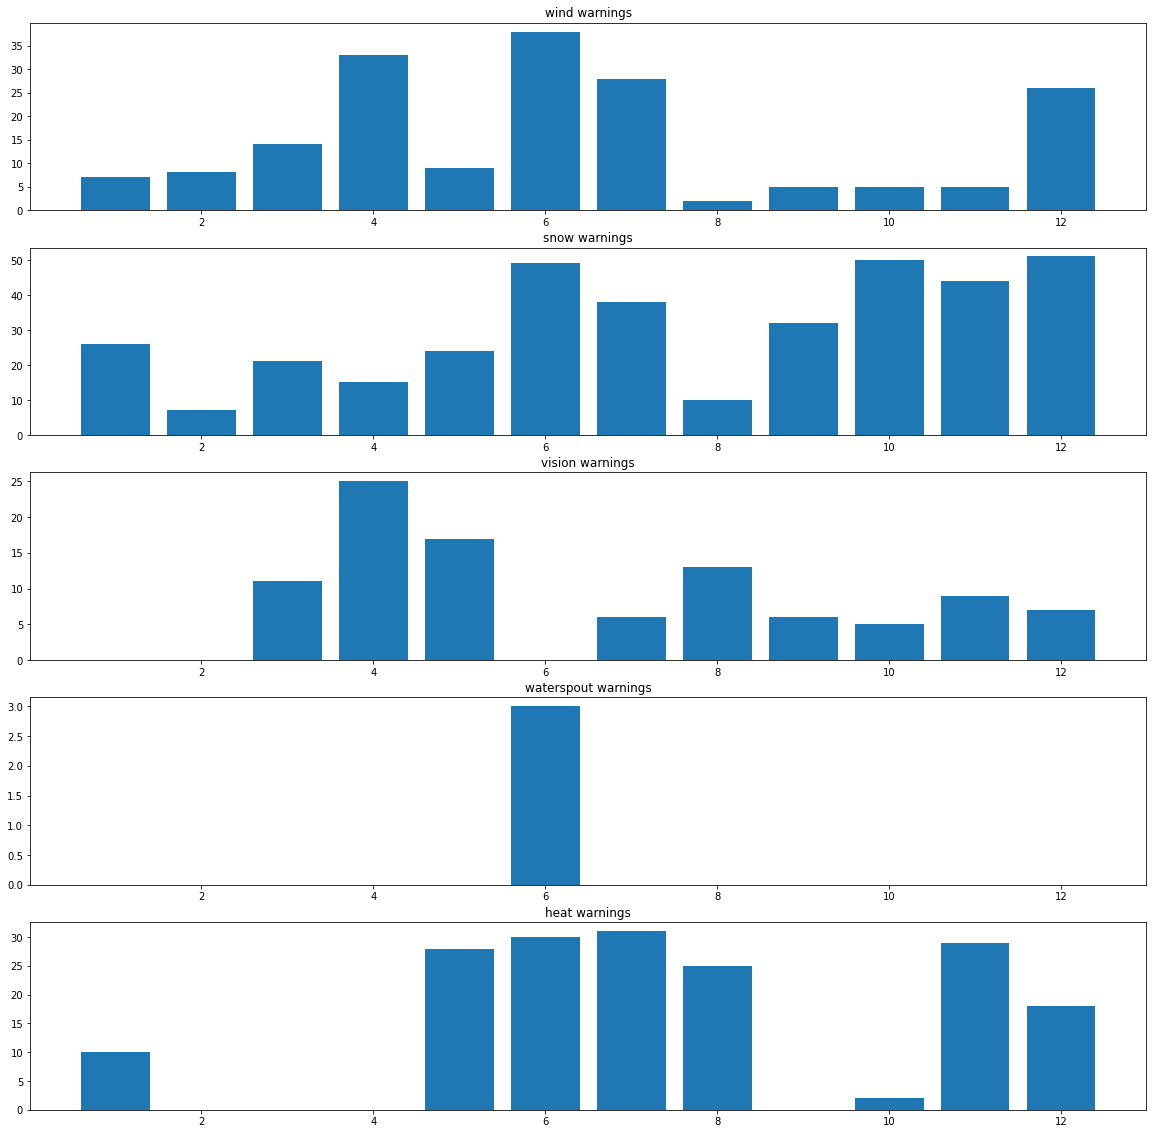

In [581]:
windwarn_list = []
windwarn = warning_df[warning_df["warning_type"] == 0]

for i in range(1, 13):
    windwarn_list.append([i, np.sum(windwarn['month_of_year'] == i)])
windwarn_df = pd.DataFrame(windwarn_list, columns=['month', 'num_warnings'])

snow_warn_list = []
snowwarn = warning_df[warning_df["warning_type"] == 1]

for i in range(1, 13):
    snow_warn_list.append([i, np.sum(snowwarn['month_of_year'] == i)])
snow_warn_df = pd.DataFrame(snow_warn_list, columns=['month', 'num_warnings'])

vision_warn_list = []
vision_warn = warning_df[warning_df["warning_type"] == 2]

for i in range(1, 13):
    vision_warn_list.append([i, np.sum(vision_warn['month_of_year'] == i)])
vision_warn_df = pd.DataFrame(vision_warn_list, columns=['month', 'num_warnings'])

storm_warn_list = []
storm_warn = warning_df[warning_df["warning_type"] == 3]

for i in range(1, 13):
    storm_warn_list.append([i, np.sum(storm_warn['month_of_year'] == i)])
storm_warn_df = pd.DataFrame(storm_warn_list, columns=['month', 'num_warnings'])

waterspout_warn_list = []
waterspout_warn = warning_df[warning_df["warning_type"] == 4]

for i in range(1, 13):
    waterspout_warn_list.append([i, np.sum(waterspout_warn['month_of_year'] == i)])
waterspout_warn_df = pd.DataFrame(waterspout_warn_list, columns=['month', 'num_warnings'])

heat_warn_list = []
heat_warn_warn = warning_df[warning_df["warning_type"] == 5]

for i in range(1, 13):
    heat_warn_list.append([i, np.sum(heat_warn_warn['month_of_year'] == i)])
heat_warn_df = pd.DataFrame(heat_warn_list, columns=['month', 'num_warnings'])

fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(5, 1, 1)
plt.title('wind warnings')
p1 = plt.bar(height="num_warnings", x='month', data=windwarn_df)
ax1 = plt.subplot(5, 1, 2)
plt.title('snow warnings')
p2 = plt.bar(height="num_warnings", x='month', data=snow_warn_df)
ax1 = plt.subplot(5, 1, 3)
plt.title('vision warnings')
p3 = plt.bar(height="num_warnings", x='month', data=vision_warn_df)
ax1 = plt.subplot(5, 1, 4)
plt.title('waterspout warnings')
p4 = plt.bar(height="num_warnings", x='month', data=waterspout_warn_df)
ax1 = plt.subplot(5, 1, 5)
plt.title('heat warnings')
p5 = plt.bar(height="num_warnings", x='month', data=heat_warn_df)